In [6]:
#cd '/Users/nikhilsingh/Downloads/Dalmia_machine_learning/Nikhil'

In [2]:
import numpy as np 
import pandas as pd 

In [279]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT sold_to_party_code,billing_date,bill_quantity FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self, month_new , df):
        #df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=month_new]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self , month_new , df):
        df, result_matrix = self.create_result_matrix(month_new, df)
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        #df.drop('month_new_dealer', axis = 1 , inplace = True)
        #result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix
instance = DB_Data(host, database, user, password, sql_query)

In [280]:
pivot = instance.pivot_data()
sep_data = pd.read_csv('Trade_Sales_Sep23.csv')
sep_data = sep_data[sep_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
sep_groupby = sep_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
sep_groupby.columns = ['2023-09']
pivot_2 = pivot.merge(sep_groupby, left_index=True , right_index = True , how = 'outer')
pivot_2 = pivot_2.fillna(0)
oct_data = pd.read_excel('Oct-23.xlsx')
oct_data = oct_data[oct_data['SOLD_PARTY_CODE'].isin(range(7000000,7100000))]
oct_groupby = oct_data.groupby('SOLD_PARTY_CODE').agg({'BILL_QTY':['sum']})
oct_groupby.columns = ['2023-10']
pivot_3 = pivot_2.merge(oct_groupby, left_index=True , right_index = True , how = 'outer')
pivot_3 = pivot_3.fillna(0)
pivot_3, result_matrix_3 = instance.state_matrix( 30 , pivot_3)

In [32]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-05'].isin(['Active_1N','Active_2N'])].index)]

In [36]:
test_1 = test[test['month_new_dealer']<=12]

In [68]:
result_1 = result_matrix_3[result_matrix_3.index.isin(test_1.index)]


In [69]:
result_1 = result_1[['2023-06','2023-07']]
result_1['actual'] = 0

In [70]:
condition = (result_1['2023-06']=='Active_3N')| (result_1['2023-07']=='Active_3N')
result_1.loc[condition, 'actual'] = 1

In [71]:
result_1['predicted'] = 0
condition = (result_1['2023-06']=='Active')& (result_1['2023-07']=='Active_1N')
result_1.loc[condition, 'predicted'] = 1

In [72]:
condition = (result_1['2023-06']=='Active_3N')
result_1.loc[condition, 'predicted'] = 1

In [73]:
from sklearn.metrics import classification_report , confusion_matrix

In [74]:
print(confusion_matrix(result_1['actual'], result_1['predicted']))
print(classification_report(result_1['actual'], result_1['predicted']))

[[206  93]
 [212 237]]
              precision    recall  f1-score   support

           0       0.49      0.69      0.57       299
           1       0.72      0.53      0.61       449

    accuracy                           0.59       748
   macro avg       0.61      0.61      0.59       748
weighted avg       0.63      0.59      0.59       748



In [281]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix, col_list,val):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        #df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop(col_list,axis = 1)
        result_matrix_2 = result_matrix[list(result_matrix.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        #print(result_matrix_2.shape)
        #print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','state_m+2'], index = result_matrix.index)
        #max_val = len(result_matrix)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i ,val-value-4:val-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'left').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'left')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'left')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df

In [282]:
pivot_prev = pd.read_csv('previous_year_data.csv')
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)
pivot_3 = pivot_prev.merge(pivot_3 , left_index = True , right_index=True , how = 'right')

In [283]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-03'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]

In [284]:
discount_df = pd.read_csv('data/discount_pivot.csv')
pd_df = pd.read_csv('data/pd_pivot.csv')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df.drop('Sold To Party Code', axis = 1 , inplace =True)
pd_df.drop('Sold To Party Code', axis = 1 , inplace =True)


In [542]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-03'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_mar, y_mar , result_1= instance_2.train_data(test_1,test_result , cols,28)

In [543]:
discount_df['avg_discount'] = discount_df[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03']].mean(axis = 1)

In [544]:
train_mar = instance_2.data(test_mar , result_1)
train_mar = instance_2.discount_pd(train_mar, discount_df , pd_df)
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']
train_mar = instance_2.district(train_mar , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_mar['actual'] = y_mar['state_m+2']
train_mar['actual'] = train_mar['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})

In [545]:
train_mar['month'] = 12

In [547]:
result_1

,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,m-11,m-12,Inactive_count,Active_3N_count,Active_2N_count,Active_1N_count,Active_count,-_count,Churn_count
7000085,Inactive,Inactive,Inactive,Inactive,Inactive,Active_3N,Active_2N,Active_1N,Active,Active_3N,Active_2N,Active_1N,4.0,2.0,2.0,2.0,1.0,NaN,NaN
7000153,Inactive,Inactive,Inactive,Inactive,Inactive,Active_3N,Active_2N,Active_1N,Active,Active,Active,Active,4.0,1.0,1.0,1.0,4.0,NaN,NaN
7000205,Active,Active,Active,Active,Active,Active,Active_2N,Active_1N,Active,Active,-,-,NaN,NaN,1.0,1.0,7.0,2.0,NaN
7000310,Active_2N,Active_1N,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active,Active,NaN,NaN,NaN,3.0,8.0,NaN,NaN
7000463,Active,Active,Active_1N,Active,Active,Active,Active,Active_1N,Active,Active,Active,Active,NaN,NaN,NaN,2.0,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039232,Inactive,Inactive,Inactive,Inactive,Inactive,Active_3N,Active_2N,Active_1N,Active,-,-,-,4.0,1.0,1.0,1.0,1.0,3.0,NaN
7039256,Inactive,Inactive,Inactive,Inactive,Inactive,Active_3N,Active_2N,Active_1N,Active,-,-,-,4.0,1.0,1.0,1.0,1.0,3.0,NaN
7039271,Active_3N,Active_2N,Active_1N,Active,Active,Active,Active_2N,Active_1N,Active,-,-,-,NaN,NaN,2.0,2.0,4.0,3.0,NaN
7039291,Active,Active,Active,Active,Active,Active,Active,Active_1N,Active,-,-,-,NaN,NaN,NaN,1.0,7.0,3.0,NaN


In [290]:

test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-02'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-02'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-03','2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_feb, y_feb , result_1= instance_2.train_data(test_1,test_result , cols,27)
discount_df['avg_discount'] = discount_df[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].mean(axis = 1)
train_feb = instance_2.data(test_feb , result_1)
train_feb = instance_2.discount_pd(train_feb, discount_df , pd_df)
train_feb = instance_2.district(train_feb , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_feb['actual'] = y_feb['state_m+2']
train_feb['actual'] = train_feb['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_feb['month'] = 11

In [291]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-01'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-01'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-02','2023-03','2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_jan, y_jan , result_1= instance_2.train_data(test_1,test_result , cols,26)
discount_df['avg_discount'] = discount_df[['2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01']].mean(axis = 1)
train_jan = instance_2.data(test_jan , result_1)
train_jan = instance_2.discount_pd(train_jan, discount_df , pd_df)
train_jan = instance_2.district(train_jan , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jan['actual'] = y_jan['state_m+2']
train_jan['actual'] = train_jan['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jan['month'] = 10

In [292]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2022-12'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2022-12'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-01','2023-02','2023-03','2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_dec, y_dec , result_1= instance_2.train_data(test_1,test_result , cols,25)
discount_df['avg_discount'] = discount_df[['2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12']].mean(axis = 1)
train_dec = instance_2.data(test_dec , result_1)
train_dec = instance_2.discount_pd(train_dec, discount_df , pd_df)
train_dec = instance_2.district(train_dec , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_dec['actual'] = y_dec['state_m+2']
train_dec['actual'] = train_dec['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_dec['month'] = 9

In [293]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2022-11'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2022-11'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_nov, y_nov , result_1= instance_2.train_data(test_1,test_result , cols,24)
discount_df['avg_discount'] = discount_df[['2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11']].mean(axis = 1)
train_nov = instance_2.data(test_nov , result_1)
train_nov = instance_2.discount_pd(train_nov, discount_df , pd_df)
train_nov = instance_2.district(train_nov , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_nov['actual'] = y_nov['state_m+2']
train_nov['actual'] = train_nov['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_nov['month'] = 8

In [294]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2022-10'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2022-10'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2022-11','2022-12','2023-01','2023-02','2023-03','2023-04','2023-05','2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()
test_oct, y_oct , result_1= instance_2.train_data(test_1,test_result , cols,23)
discount_df['avg_discount'] = discount_df[['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2021-11','2021-12','2022-01','2022-02','2022-03','2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10']].mean(axis = 1)
train_oct = instance_2.data(test_oct , result_1)
train_oct = instance_2.discount_pd(train_oct, discount_df , pd_df)
train_oct = instance_2.district(train_oct , distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_oct['actual'] = y_oct['state_m+2']
train_oct['actual'] = train_oct['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_oct['month'] = 7

,m-1,m-2,m-3,m-4,m-5,m-6,m-7,m-8,m-9,m-10,...,m-16,m-17,m-18,m-19,m-20,m-21,m-22,m-23,m-24,avg_sales
7000085,30.0,0.0,0.0,0.0,30.0,25.0,25.0,0.0,25.0,25.0,...,25.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,11.250000
7000153,16.0,2.0,27.5,49.0,14.5,18.25,62.5,0.0,12.5,32.0,...,19.0,100.5,16.9,4.0,39.0,67.0,80.0,48.0,111.5,44.235417
7000205,5.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.521739
7000310,5.0,0.0,20.0,5.0,23.0,10.0,34.0,18.0,21.0,5.0,...,33.5,48.0,41.0,35.0,72.0,42.0,50.0,27.0,114.0,32.979167
7000463,25.0,30.0,25.0,20.0,12.0,12.0,13.0,0.0,0.0,0.0,...,0.0,31.0,0.0,0.0,27.0,0.0,27.0,26.0,63.0,15.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039232,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.086957
7039256,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.521739
7039271,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.434783
7039291,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.304348


In [301]:
train_df = pd.concat([train_mar, train_feb , train_jan , train_dec, train_nov, train_oct], axis = 0)

In [305]:
X = train_df.drop(['actual','month', 'm-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
y = train_df['actual']

In [310]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree Inactive")
        self.save_model(model, "Decision_Tree Inactive") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf',class_weight={1:2.0})
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM Inactive")
        self.save_model(model, "SVM Inactive")

    def train_random_forest(self):
        model = RandomForestClassifier(n_estimators=61)
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest Inactive")
        self.save_model(model, "Random Forest Inactive")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors Inactive")
        self.save_model(model, "K-Nearest Neighbors Inactive")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Inactive")
        self.save_model(model, "XGBoost Inactive")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest Inactive")
        self.save_model(model, "XGBoost Random Forest Inactive")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob

In [311]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = X.fillna(0)
X_1 = sc.fit_transform(X)


#y_1 = y_1['label']
trainer = Training_module(X_1, y)

Classification Report for Random Forest Inactive:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       706
           1       0.84      0.86      0.85       544

    accuracy                           0.87      1250
   macro avg       0.87      0.87      0.87      1250
weighted avg       0.87      0.87      0.87      1250

Confusion Matrix for Random Forest Inactive:

[[619  87]
 [ 74 470]]


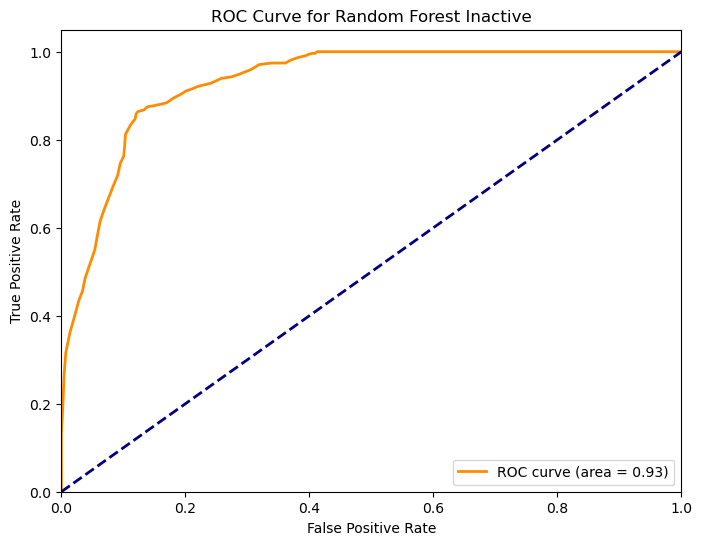

In [312]:
trainer.train_random_forest()

Classification Report for Decision Tree Inactive:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       706
           1       0.78      0.78      0.78       544

    accuracy                           0.81      1250
   macro avg       0.81      0.81      0.81      1250
weighted avg       0.81      0.81      0.81      1250

Confusion Matrix for Decision Tree Inactive:

[[588 118]
 [118 426]]


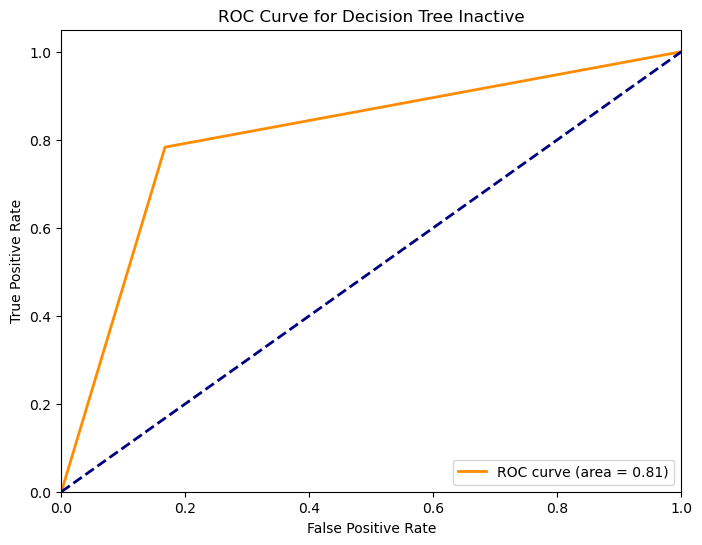

In [313]:
trainer.train_decision_tree()

Classification Report for SVM Inactive:

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       706
           1       0.76      0.91      0.83       544

    accuracy                           0.83      1250
   macro avg       0.84      0.84      0.83      1250
weighted avg       0.85      0.83      0.83      1250

Confusion Matrix for SVM Inactive:

[[548 158]
 [ 51 493]]


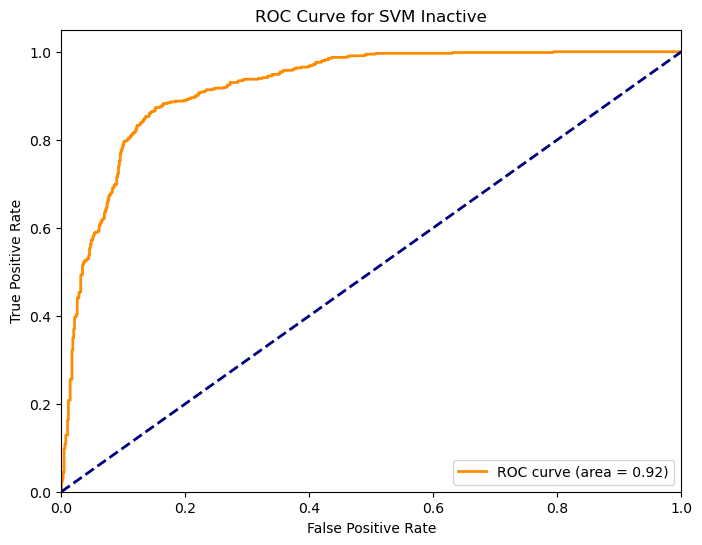

In [314]:
trainer.train_svm()

Classification Report for XGBoost Inactive:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       706
           1       0.84      0.82      0.83       544

    accuracy                           0.85      1250
   macro avg       0.85      0.85      0.85      1250
weighted avg       0.85      0.85      0.85      1250

Confusion Matrix for XGBoost Inactive:

[[620  86]
 [ 99 445]]


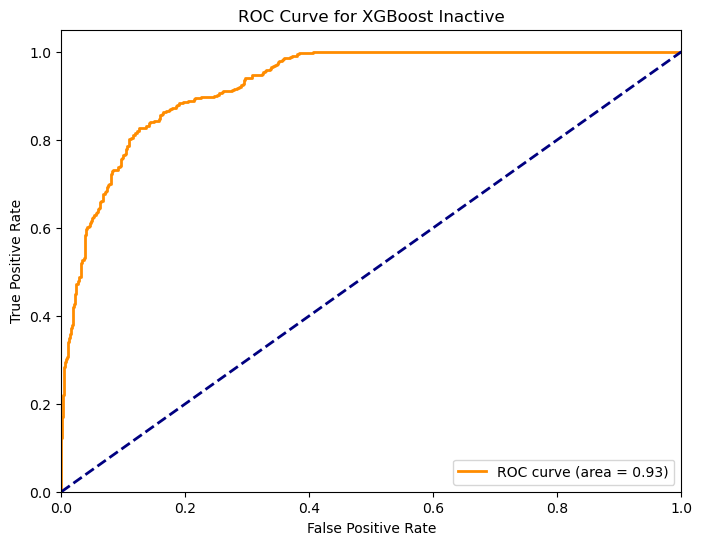

In [315]:
trainer.train_xgboost()

Classification Report for XGBoost Random Forest Inactive:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       706
           1       0.84      0.87      0.86       544

    accuracy                           0.87      1250
   macro avg       0.87      0.87      0.87      1250
weighted avg       0.87      0.87      0.87      1250

Confusion Matrix for XGBoost Random Forest Inactive:

[[618  88]
 [ 72 472]]


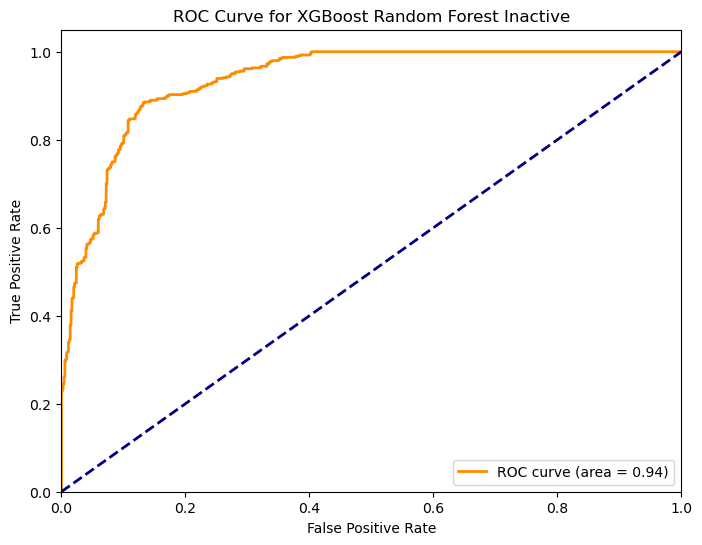

In [316]:
trainer.train_xgboost_rf()

In [317]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["06'23","07'23","08'23"])==False]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']

,sold_to_party_code,avg_discount,avg_pd
sold_to_party_code,,,
7000004,7000004,23911.200000,7874.97
7000010,7000010,2321.050000,937.50
7000022,7000022,2904.880000,1562.50
7000025,7000025,41436.415000,13125.00
7000029,7000029,21639.865000,5859.37
...,...,...,...
7041078,7041078,546.900000,1640.70
7041083,7041083,989.900000,2969.70
7041085,7041085,195.333333,586.00


In [327]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-05'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-05'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-06','2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-06', '2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()

test_may, y_may , result_1= instance_2.train_data(test_1,test_result , cols,30)
train_may = instance_2.data(test_may , result_1)
train_may = instance_2.discount_pd(train_may, discount_groupby , discount_groupby)
train_may = instance_2.district(train_may, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_may['actual'] = y_may['state_m+2']
train_may['actual'] = train_may['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_may['month'] = 11

In [328]:
X_val = train_may.drop(['actual','month', 'm-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_val= X_val.fillna(0)
X_val_1 = sc.fit_transform(X_val)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_val_1)
pred_proba = loaded_model.predict_proba(X_val_1)[:,1]
train_may['predicted'] = predictions
train_may['predict_proba'] = pred_proba


In [330]:
print(confusion_matrix(train_may['actual'], train_may['predicted']))
print(classification_report(train_may['actual'], train_may['predicted']))

[[363  19]
 [ 55 312]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       382
           1       0.94      0.85      0.89       367

    accuracy                           0.90       749
   macro avg       0.91      0.90      0.90       749
weighted avg       0.90      0.90      0.90       749



In [444]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
discount_24 = discount_24[discount_24['Month'].isin(["08'23"])==False]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']

In [368]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()

test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,31)
train_jun = instance_2.data(test_jun , result_1)
train_jun = instance_2.discount_pd(train_jun, discount_groupby , discount_groupby)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 11

In [465]:
discount_24['Month'] = discount_24['Month'].replace({"04'23":'2023-04',"05'23":'2023-05',"06'23":'2023-06',
                                                    "07'23":'2023-07',"08'23":'2023-08'})

In [467]:
discount_24 = discount_24.fillna(0)

In [473]:
discount_group_month = discount_24.groupby(['Cus Code','Month']).agg({'Total Discount': 'sum','PD': 'sum' }).reset_index()
discount_group_month.columns = ['Sold To Party Code', 'Month Year', 'Total Discount', 'PD']
pivot_table_discount = pd.pivot_table(discount_group_month, values='Total Discount', columns='Month Year', index='Sold To Party Code')
pivot_table_discount = pivot_table_discount.fillna(0)
pivot_table_pd = pd.pivot_table(discount_group_month, values='PD', columns='Month Year', index='Sold To Party Code')
pivot_table_pd = pivot_table_pd.fillna(0)

In [476]:
pivot_table_pd.drop(["02'23","03'23"],axis = 1, inplace= True)
pivot_table_discount.drop(["02'23","03'23"],axis = 1, inplace= True)

In [477]:
discount_df = discount_df.merge(pivot_table_discount, left_index = True , right_index = True, how = 'outer')
pd_df = pd_df.merge(pivot_table_pd, left_index = True , right_index = True, how = 'outer')

In [480]:
discount_df = discount_df.fillna(0)
pd_df = pd_df.fillna(0)

In [369]:
X_jun = train_jun.drop(['actual','month', 'm-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted'] = predictions
train_jun['predict_proba'] = pred_proba

In [370]:
print(confusion_matrix(train_jun['actual'], train_jun['predicted']))
print(classification_report(train_jun['actual'], train_jun['predicted']))

[[432  21]
 [ 50 303]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       453
           1       0.94      0.86      0.90       353

    accuracy                           0.91       806
   macro avg       0.92      0.91      0.91       806
weighted avg       0.91      0.91      0.91       806



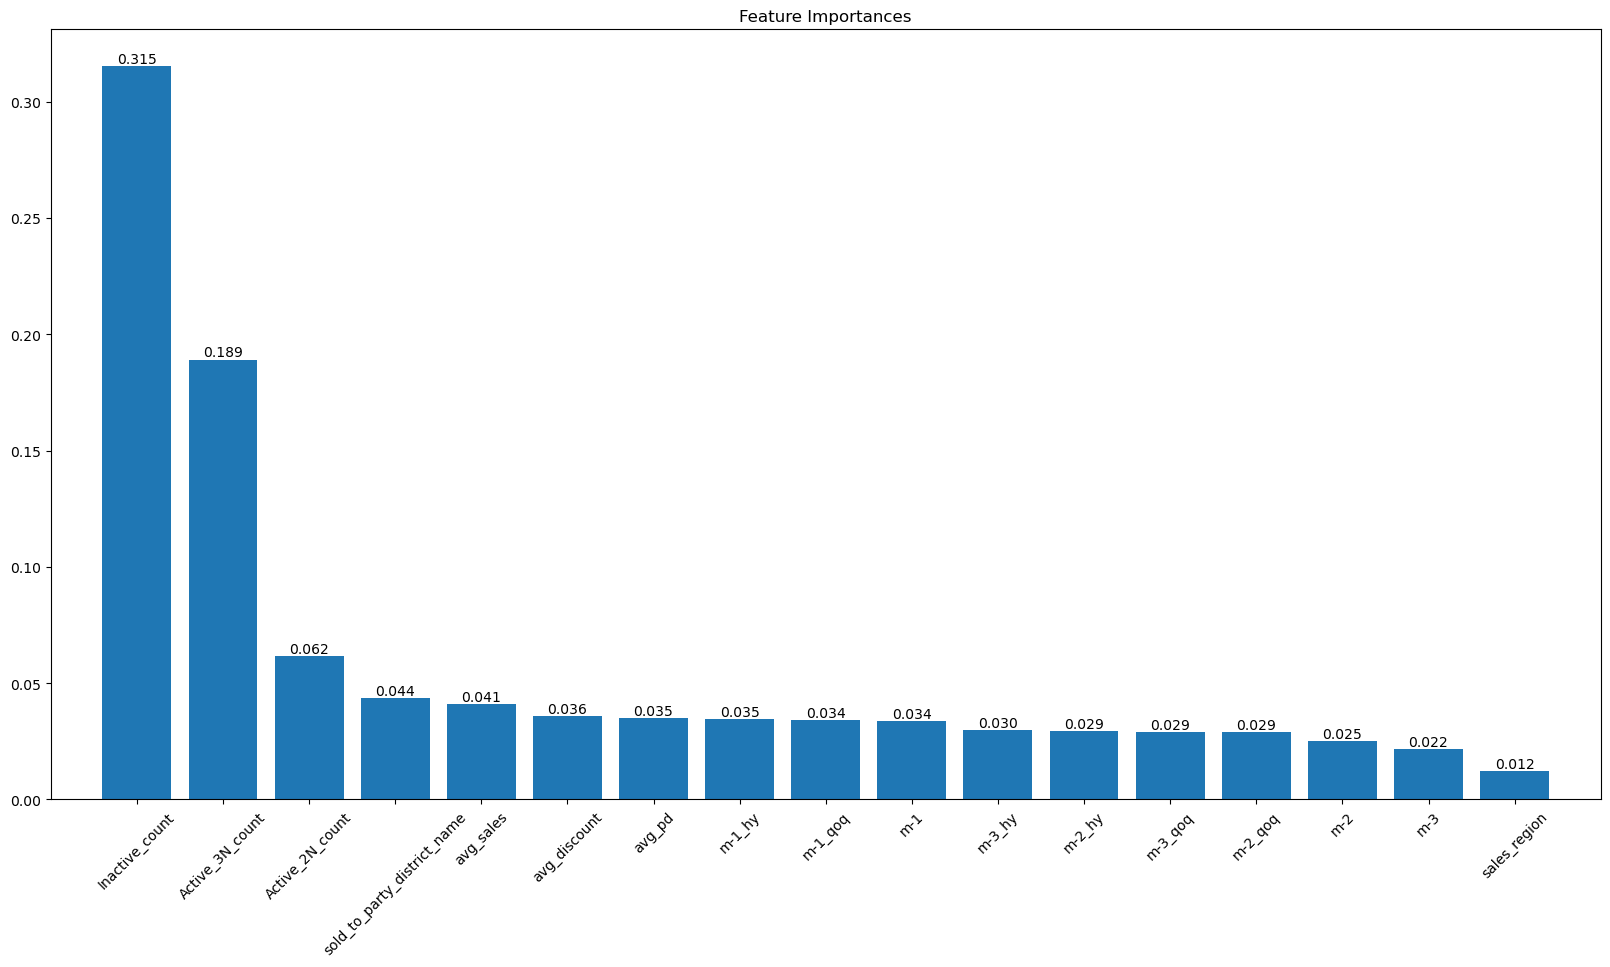

In [371]:
importances = loaded_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 10))
plt.title("Feature Importances")
bars = plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])

# Add annotations for feature importance values on the bars
for bar, importance in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{importance:.3f}", ha='center', va='bottom')

plt.show()

In [409]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-10'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-10'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = None
test_1 = test.drop(['month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
test_1 = test_1.fillna(0)


In [410]:
test_1.columns

Index(['2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
       '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03',
       '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10'],
      dtype='object')

In [411]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')
#discount_24 = discount_24[discount_24['Month'].isin(["07'23","08'23"])==False]
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']
discount_groupby.index = discount_groupby['sold_to_party_code']
test_1 = test_1[[ '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09']]
result_1 = test_result[['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09']]
test_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'][::-1]
train_oct = instance_2.data(test_1 , result_1)
train_oct = instance_2.discount_pd(train_oct, discount_groupby , discount_groupby)
train_oct = instance_2.district(train_oct, distt_df, region_df)

In [412]:
X_oct = train_oct.drop(['m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_oct= X_oct.fillna(0)
X_oct_1 = sc.fit_transform(X_oct)
loaded_model = joblib.load('SVM Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_oct_1)
pred_proba = loaded_model.predict_proba(X_oct_1)[:,1]
train_oct['predicted'] = predictions
train_oct['predict_proba'] = pred_proba


In [413]:
train_oct['predicted'].value_counts()

0    680
1    119
Name: predicted, dtype: int64

In [414]:
train_jun['actual'].value_counts()

0    453
1    353
Name: actual, dtype: int64

In [415]:
train_oct['predicted'].value_counts()

0    680
1    119
Name: predicted, dtype: int64

0.0    724
1.0     20
2.0     15
3.0     12
4.0     11
6.0      6
7.0      5
5.0      3
8.0      2
9.0      1
Name: Inactive_count, dtype: int64

In [431]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-08'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-09','2023-10']
test_1 = test.drop(['2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()

test_aug, y_aug , result_1= instance_2.train_data(test_1,test_result , cols,33)
train_aug = instance_2.data(test_aug , result_1)
train_aug = instance_2.discount_pd(train_aug, discount_groupby , discount_groupby)
train_aug = instance_2.district(train_aug, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['actual'] = y_aug['state_m+2']
train_aug['actual'] = train_aug['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_aug['month'] = 11

In [432]:
X_aug = train_aug.drop(['actual','month','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_aug= X_aug.fillna(0)
X_aug_1 = sc.fit_transform(X_aug)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_aug_1)
pred_proba = loaded_model.predict_proba(X_aug_1)[:,1]
train_aug['predicted'] = predictions
train_aug['predict_proba'] = pred_proba

In [433]:
print(confusion_matrix(train_aug['actual'],train_aug['predicted']))
print(classification_report(train_aug['actual'],train_aug['predicted']))

[[318  35]
 [292  86]]
              precision    recall  f1-score   support

           0       0.52      0.90      0.66       353
           1       0.71      0.23      0.34       378

    accuracy                           0.55       731
   macro avg       0.62      0.56      0.50       731
weighted avg       0.62      0.55      0.50       731



In [ ]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()

test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,31)
train_jun = instance_2.data(test_jun , result_1)
train_jun = instance_2.discount_pd(train_jun, discount_groupby , discount_groupby)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 11

In [437]:
y_aug['state_m+2'].value_counts()

Active_3N    378
Active       252
Active_1N    101
Name: state_m+2, dtype: int64

In [443]:
train_may['predicted'].value_counts()

0    418
1    331
Name: predicted, dtype: int64

In [445]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-08','2023-09','2023-10']
test_1 = test.drop([ '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
instance_2 = Train()

test_jul, y_jul , result_1= instance_2.train_data(test_1,test_result , cols,32)
train_jul = instance_2.data(test_jul , result_1)
train_jul = instance_2.discount_pd(train_jul, discount_groupby , discount_groupby)
train_jul = instance_2.district(train_jul, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['actual'] = y_jul['state_m+2']
train_jul['actual'] = train_jul['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['month'] = 11

In [446]:
X_jul = train_jul.drop(['actual','month','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_jul= X_jul.fillna(0)
X_jul_1 = sc.fit_transform(X_jul)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_1)
pred_proba = loaded_model.predict_proba(X_jul_1)[:,1]
train_jul['predicted'] = predictions
train_jul['predict_proba'] = pred_proba

In [452]:
X_jun = train_jun.drop(['actual','month','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count','predicted' , 'predict_proba'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted_1'] = predictions
#train_jul['predict_proba'] = pred_proba

In [457]:
train_jul['actual'].value_counts()

0    494
1    420
Name: actual, dtype: int64

In [458]:
discount_df

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,avg_discount
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,94330.525000,38663.000000,139006.519375,75973.155000,39049.915000,43103.795000,32120.984375,9198.375000,37494.078125,24981.570000,...,12789.410000,12557.500000,6107.500000,24410.833333,24348.833333,73613.353333,67405.280000,82557.601600,88128.287200,24312.610564
7000010,21072.000000,16063.000000,0.000000,17422.000000,10951.500000,0.000000,32494.000000,9263.000000,10978.750000,9628.000000,...,17294.730000,6986.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7313.341667
7000015,2500.500000,23575.500000,40768.171875,44202.070625,41536.441250,33507.065000,52001.452396,33917.395833,19925.958333,16623.531250,...,27085.045300,38413.882500,20554.667500,24038.457800,17762.312500,0.000000,15070.000000,0.000000,0.000000,30478.045584
7000019,4577.583333,27605.363333,84787.850208,72268.177083,89864.439271,63181.145833,1239.583333,6081.645833,1239.583333,1239.583333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,919.998264
7000022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4631.744767,6078.026067,11154.146667,9349.291667,1677.104167,11594.455767,5195.846667,256.666667,6639.940067,2814.719106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,50.440192,11137.630192,29.423445
7039799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,29.643908,1006.203908,17.292280
7039800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,25563.029558,26598.746225,26598.746225,27548.746225,14911.767242


In [530]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-06'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = ['2023-07', '2023-08','2023-09','2023-10']
test_1 = test.drop(['2023-07', '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05']].mean(axis = 1)
instance_2 = Train()
test_jun, y_jun , result_1= instance_2.train_data(test_1,test_result , cols,31)
train_jun = instance_2.data(test_jun , result_1)
train_jun = instance_2.discount_pd(train_jun, discount_df , pd_df)
train_jun = instance_2.district(train_jun, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['actual'] = y_jun['state_m+2']
train_jun['actual'] = train_jun['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jun['month'] = 11

In [531]:
X_jun = train_jun.drop(['actual','month','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_jun= X_jun.fillna(0)
X_jun_1 = sc.fit_transform(X_jun)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jun_1)
pred_proba = loaded_model.predict_proba(X_jun_1)[:,1]
train_jun['predicted'] = predictions
train_jun['predict_proba'] = pred_proba

Active_1N    806
Name: m-5, dtype: int64

In [532]:
print(confusion_matrix(train_jun['actual'],train_jun['predicted']))
print(classification_report(train_jun['actual'],train_jun['predicted']))

[[432  21]
 [ 39 314]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       453
           1       0.94      0.89      0.91       353

    accuracy                           0.93       806
   macro avg       0.93      0.92      0.92       806
weighted avg       0.93      0.93      0.93       806



In [522]:
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
test = pivot_3[pivot_3.index.isin(result_matrix_3[result_matrix_3['2023-07'].isin(['Active_1N'])].index)]
test_result = result_matrix_3[result_matrix_3.index.isin(test.index)]
cols = [ '2023-08','2023-09','2023-10']
test_1 = test.drop([ '2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
#test_result = test_result.drop( ['2023-08','2023-09', '2023-10','month_new_dealer'],axis = 1)
discount_df['avg_discount'] = discount_df[[ '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
pd_df['avg_pd'] = pd_df[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05','2023-06']].mean(axis = 1)
instance_2 = Train()
test_jul, y_jul , result_1= instance_2.train_data(test_1,test_result , cols,32)
test_result = test_result[['2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06']]
test_result.columns = list(result_1.columns)[::-1]
train_jul = instance_2.data(test_jul , test_result)
train_jul = instance_2.discount_pd(train_jul, discount_groupby , discount_groupby)
train_jul = instance_2.district(train_jul, distt_df, region_df)
#y['state_m+1'] = y['state_m+1'].apply({'Active_3N':1, 'Active_1N':0 , 'Active':0})
train_jul['actual'] = y_jul['state_m+2']
train_jul['actual'] = train_jul['actual'].replace({'Active_3N':1, 'Active_1N':0 , 'Active':0})

In [494]:
X_jul = train_jul.drop(['actual','m-1_yoy' , 'm-2_yoy', 'm-3_yoy' , 'Active_1N_count'], axis = 1 )
X_jul= X_jul.fillna(0)
X_jul_1 = sc.fit_transform(X_jul)
loaded_model = joblib.load('Random Forest Inactive_model.pkl')

# Make predictions using the loaded model
predictions = loaded_model.predict(X_jul_1)
pred_proba = loaded_model.predict_proba(X_jul_1)[:,1]
train_jul['predicted'] = predictions
train_jul['predict_proba'] = pred_proba

In [536]:
username = "bridge.dcbldb@dalmiabharat.com"
password = "Supersonic@!@#"